In [1]:
#TD tasa desempleo
#IPO ingreso promedio
#manzana estratificada -> estrato
#uso del suelo
#Indice de pobreza
#poblacion


import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import tqdm as tqdm
from shapely.geometry import Point
import dateutil.parser
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pyproj import Transformer

from google.colab import drive
drive.mount('/content/drive')
path_opencp="drive/MyDrive/PDH | Thesis/Experiments/PredictCode/"
path_exp="drive/MyDrive/PDH | Thesis/Experiments/Fairness_Data/"

import sys, os.path, os
sys.path.insert(0, os.path.abspath(path_opencp))
sys.path.insert(0, os.path.abspath(path_exp))

import open_cp.sepp_kde_2 as sepp_kde

os.chdir("drive/MyDrive/PDH | Thesis/Experiments/Fairness_Data/")

Mounted at /content/drive


Loading data

In [2]:
gdf_events = gpd.read_file("Bogota/Raw Data/raw_data_2018_2021_200x200_random_synthetic.geojson")
#gdf_events=gdf_events[(gdf_events["Nombre de la localidad"]=='CHAPINERO') | (gdf_events["Nombre de la localidad"]=='USAQUEN') | (gdf_events["Nombre de la localidad"]=='TEUSAQUILLO') | (gdf_events["Nombre de la localidad"]=='BARRIOS UNIDOS')]
#gdf_events=gdf_events[(gdf_events["Nombre de la localidad"]=='CHAPINERO') ]

gdf_events['fecha_crimen'] = pd.to_datetime(gdf_events['fecha_crimen']).dt.floor('H')
gdf_events['fecha_crimen'] = gdf_events['fecha_crimen'].apply(lambda x: x.replace(minute=0, second=0))
gdf_events.head()

<ipython-input-2-12c06235e2ad>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  gdf_events['fecha_crimen'] = pd.to_datetime(gdf_events['fecha_crimen']).dt.floor('H')


,fecha_crimen,LONGITUD_X,LATITUD_Y,Nombre de la localidad,source,geometry
0,2018-01-01 22:00:00,-74.107760,4.503149,USME,real,POINT (-74.10776 4.50315)
1,2018-01-01 23:00:00,-74.090022,4.516403,USME,real,POINT (-74.09002 4.5164)
2,2018-01-01 08:00:00,-74.149555,4.552983,CIUDAD BOLIVAR,real,POINT (-74.14956 4.55298)
3,2018-01-01 10:00:00,-74.173136,4.565343,CIUDAD BOLIVAR,real,POINT (-74.17314 4.56534)
4,2018-01-01 16:00:00,-74.143819,4.569156,CIUDAD BOLIVAR,real,POINT (-74.14382 4.56916)


In [3]:
#gdf_events['LATITUD_Y'] = gdf_events.geometry.y
#gdf_events['LONGITUD_X'] = gdf_events.geometry.x
#gdf_events = gdf_events.to_crs('EPSG:3116')
gdf_events['coord_y'] = gdf_events.geometry.y
gdf_events['coord_x'] = gdf_events.geometry.x
#gdf_events = gdf_events.to_crs('EPSG:4326')

null_summary = gdf_events.isnull().sum()
# Filtrar solo columnas que tienen al menos un NaN
null_columns = null_summary[null_summary > 0]
# Mostrar resultado
print("Columnas con valores nulos:")
print(null_columns)

Columnas con valores nulos:
Series([], dtype: int64)


In [4]:
localidades=gpd.read_file('Bogota/Raw Data/localidades_bogota.geojson')
#localidades=localidades[(localidades["LocNombre"]=='CHAPINERO') | (localidades["LocNombre"]=='USAQUEN') | (localidades["LocNombre"]=='TEUSAQUILLO') | (localidades["LocNombre"]=='BARRIOS UNIDOS')]
#localidades=localidades[(localidades["LocNombre"]=='CHAPINERO')]
localidades = localidades.to_crs('EPSG:4326')

geometrias=gpd.GeoSeries([i for i in localidades.geometry])
geo=geometrias.unary_union

minx=geo.bounds[0]
miny=geo.bounds[1]
maxx=geo.bounds[2]
maxy=geo.bounds[3]

bbox = {'lon_min':minx, 'lat_min':miny, 'lon_max':maxx, 'lat_max':maxy}

x_range=abs(maxx-minx)
y_range=abs(maxy-miny)
range_max=max(x_range,y_range)

<ipython-input-4-2be4c9a80a3a>:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geo=geometrias.unary_union


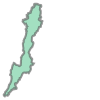

In [5]:
geo

In [6]:
bbox

{'lon_min': -74.44977952799991,
 'lat_min': 3.7310303420000537,
 'lon_max': -73.98653427799991,
 'lat_max': 4.836779095000054}

In [7]:
gdf_events_train = gdf_events[gdf_events.fecha_crimen>=pd.to_datetime("2021-01-01")]
#gdf_events_train=gdf_events
timestamps = gdf_events_train.fecha_crimen.values
xcoords, ycoords = (gdf_events_train.coord_x.values, gdf_events_train.coord_y.values)

minx=gdf_events_train.LONGITUD_X.min()
miny=gdf_events_train.LATITUD_Y.min()
maxx=gdf_events_train.LONGITUD_X.max()
maxy=gdf_events_train.LATITUD_Y.max()

bbox = {'lon_min':minx, 'lat_min':miny, 'lon_max':maxx, 'lat_max':maxy}

events_df=gdf_events_train[['fecha_crimen','geometry']]
events_df.head()

,fecha_crimen,geometry
90802,2021-01-01 07:00:00,POINT (-74.11253 4.47307)
90803,2021-01-01 07:00:00,POINT (-74.11148 4.47404)
90804,2021-01-01 08:00:00,POINT (-74.11162 4.47348)
90805,2021-01-01 21:00:00,POINT (-74.11082 4.47457)
90806,2021-01-01 09:00:00,POINT (-74.1182 4.52128)


#Generating bounding box off 1kmx1km fo the total area of the data

In [8]:
import geopandas as gpd
from shapely.geometry import box
from pyproj import Transformer, CRS
import numpy as np

def generar_grilla_bbox(bbox, cell_size=1000, crs='EPSG:4326'):
    """
    Genera un GeoDataFrame de celdas cuadradas que cubren el bounding box dado.

    Parámetros:
    - bbox: dict con lat/lon {'lat_min', 'lat_max', 'lon_min', 'lon_max'}
    - cell_size: tamaño de celda en metros
    - crs: CRS de entrada del bbox (por defecto WGS84)

    Retorna:
    - GeoDataFrame con polígonos de celdas
    """
    # Transformar bbox a CRS proyectado en metros
    transformer = Transformer.from_crs(crs, 'EPSG:3857', always_xy=True)
    x_min, y_min = transformer.transform(bbox['lon_min'], bbox['lat_min'])
    x_max, y_max = transformer.transform(bbox['lon_max'], bbox['lat_max'])

    # Crear rejilla
    x_coords = np.arange(x_min, x_max, cell_size)
    y_coords = np.arange(y_min, y_max, cell_size)

    polygons = []
    for x in x_coords:
        for y in y_coords:
            cell = box(x, y, x + cell_size, y + cell_size)
            polygons.append(cell)

    gdf = gpd.GeoDataFrame(geometry=polygons, crs='EPSG:3857')
    return gdf.to_crs(crs)

In [9]:
gdf_grilla = generar_grilla_bbox(bbox, cell_size=1000)
gdf_grilla.to_file('Bogota/Raw Data/grid_1kmx1km_bogora.geojson',driver='GeoJSON')

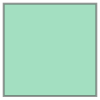

In [10]:
gdf_grilla.geometry[0]

#Making sepp predictions

In [18]:
gdf_grilla = gpd.read_file('Bogota/Raw Data/grid_1kmx1km_bogota_covariates.geojson',driver='GeoJSON')

/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


In [49]:
lambda_grid, predicted_events, hotspot_map, metrics= sepp_kde.simulate_sepp(events_df,
                                                                            bbox,
                                                                            crs='EPSG:4326',
                                                                            cell_size_m=1000,
                                                                            time_step_hours=24,
                                                                            horizon_days=3,
                                                                            bandwidth_space=1000,
                                                                            bandwidth_time=168)

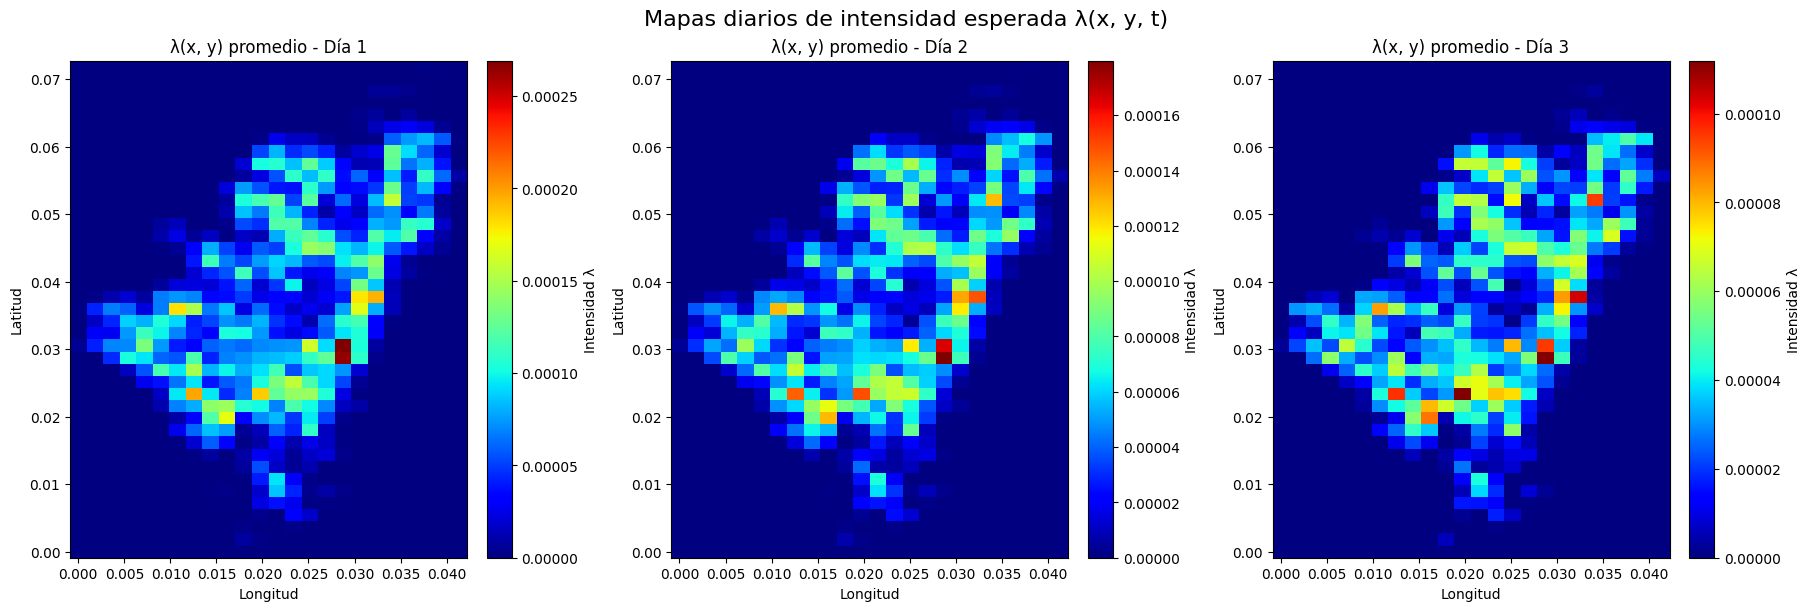

In [50]:
import matplotlib.pyplot as plt
from pyproj import Transformer
# Supongamos que el resultado ya está en lambda_grid
# lambda_grid.shape = (nx, ny, nt), con nt = 3 días * 4 pasos (6h cada uno) = 12

n_steps_per_day = 24 // 24 # 4 pasos por día
days = lambda_grid.shape[2] // n_steps_per_day

# Coordenadas de grilla
x_coords = np.arange(lambda_grid.shape[0]) * 200
y_coords = np.arange(lambda_grid.shape[1]) * 200
xx, yy = np.meshgrid(x_coords, y_coords, indexing='ij')

# Reproyectar a lat/lon
transformer = Transformer.from_crs('EPSG:3857', 'EPSG:4326', always_xy=True)
lon, lat = transformer.transform(xx, yy)

# Plot por día
fig, axs = plt.subplots(1, days, figsize=(18, 6), constrained_layout=True)
for d in range(days):
    lambda_day = lambda_grid[:, :, d * n_steps_per_day:(d + 1) * n_steps_per_day].mean(axis=2)
    ax = axs[d]
    #pcm = ax.contourf(lon, lat, lambda_day, cmap='jet')
    pcm = ax.pcolormesh(lon, lat, lambda_day, cmap='jet')

    ##ax.scatter(gdf_events['LONGITUD_X'], gdf_events['LATITUD_Y'], s=3, color='black', alpha=0.3)
    ax.set_title(f"λ(x, y) promedio - Día {d+1}")
    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")
    fig.colorbar(pcm, ax=ax, orientation='vertical', label='Intensidad λ')

plt.suptitle("Mapas diarios de intensidad esperada λ(x, y, t)", fontsize=16)
plt.show()

In [37]:
lambda_promedio = lambda_grid[:, :, 2]
lambda_flat = lambda_promedio.ravel()  # convierte (nx, ny) en (nx*ny,)
gdf_grilla = gdf_grilla.sort_values(by='grid_id').reset_index(drop=True)  # asegura mismo orden
gdf_grilla['lambda_predicha'] = lambda_flat

<Axes: >

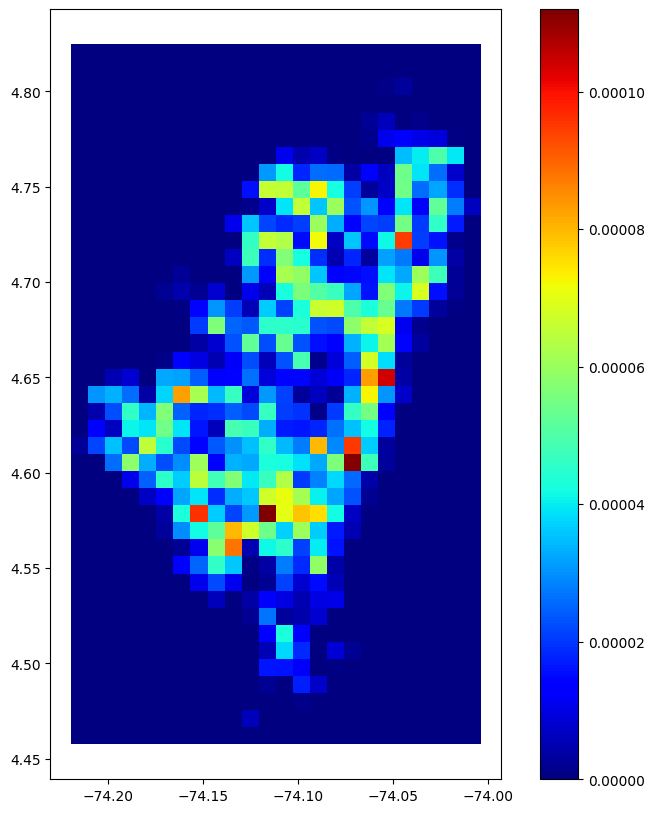

In [38]:
gdf_grilla.plot(column='lambda_predicha', cmap='jet', legend=True, figsize=(10,10))

In [44]:
gdf_grilla.to_file('Bogota/Predictions/test_prediction_1.geojson',driver='GeoJSON')